# Sachs et al. 2005

In [1]:
import random
import time

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import chisq

import pandas as pd
import cstrees.scoring as sc
import cstrees.learning as ctl
import numpy as np

%load_ext autoreload
%autoreload 2

/usr/local/Caskroom/miniconda/base/envs/cstrees/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

In [2]:
sachs = pd.read_csv('../data/sachs_obs_data.csv')

As a pre-processing step, we make all variables binary.

In [3]:
# Binarize data and add a row at the top of the dataframe containing variable cardinalities
sachsnp = sachs.to_numpy()

sachs2 = np.zeros([len(sachs), len(list(sachs.columns))], int)

for i in range(len(list(sachs.columns))):
    sachs2[:,i] = pd.cut(sachsnp[:,i], 2, labels = False)
    
# add row with state space cardinalities
sachs2states = np.zeros([len(sachs) + 1, len(list(sachs.columns))], int)
sachs2states[0,:] = [2 for i in range(len(list(sachs.columns)))]
for i in range(len(sachs)):
    sachs2states[i+1,:] = sachs2[i,:]
    
sachsdf = pd.DataFrame(sachs2states, columns = list(sachs.columns))

## MCMC sampling

We run without restricting the parent sets according to a CPDAG (poss_cvars=None).
To run with this restriction uncomment the commented lines of code and let the poss_cvars=poss_cvars in sc.order_score_tables.

In [4]:
# pcgraph = pc(sachsdf[1:].values, 0.9, "chisq", node_names=sachsdf.columns)
# poss_cvars = ctl.causallearn_graph_to_posscvars(pcgraph, labels=sachsdf.columns)
# print("Possible context variables per node:", poss_cvars)
np.random.seed(1)
random.seed(1)
start = time.time()
score_table, context_scores, context_counts = sc.order_score_tables(sachsdf,
                                                                    max_cvars=2,
                                                                    alpha_tot=1.0,
                                                                    method="BDeu",
                                                                    poss_cvars=None)

orders, scores = ctl.gibbs_order_sampler(5000, score_table)
end = time.time()
print('Computation time in seconds:', end - start)

Gibbs order sampler: 100%|██████████| 5000/5000 [00:00<00:00, 7991.33it/s]

Computation time in seconds: 73.76801800727844


Optimal variable ordering

In [5]:
sachsmaporder = orders[scores.index(max(scores))]
print(sachsmaporder)

['Raf', 'PIP3', 'PLCg', 'PIP2', 'PKA', 'JNK', 'PKC', 'Akt', 'Erk', 'Mek', 'p38']


Get optimal tree for ordering

In [6]:
sachsopttree = ctl._optimal_cstree_given_order(sachsmaporder, context_scores)

Dataframe representation

In [7]:
sachsopttree.to_df()

,Raf,PIP3,PLCg,PIP2,PKA,JNK,PKC,Akt,Erk,Mek,p38
0,2,2,2,2,2,2,2,2,2,2,2
1,*,-,-,-,-,-,-,-,-,-,-
2,*,*,-,-,-,-,-,-,-,-,-
3,*,0,*,-,-,-,-,-,-,-,-
4,*,1,0,-,-,-,-,-,-,-,-
5,*,1,1,-,-,-,-,-,-,-,-
6,*,*,*,0,-,-,-,-,-,-,-
7,0,*,*,1,-,-,-,-,-,-,-
8,1,*,*,1,-,-,-,-,-,-,-
9,*,*,0,*,*,-,-,-,-,-,-


## LDAG representation

Print the LDAG representation of the learned CStree model

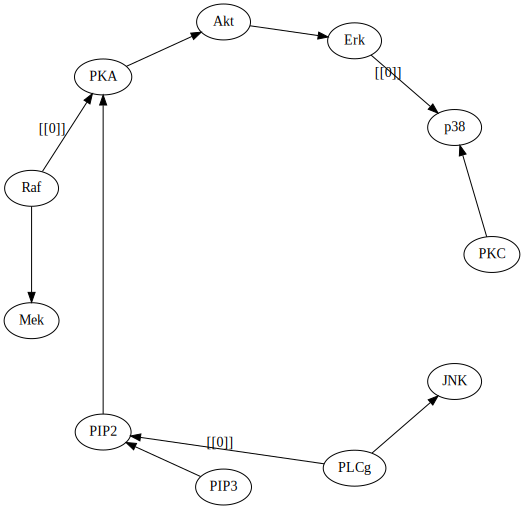

In [8]:

LDAG = sachsopttree.to_LDAG() 
agraph = LDAG.plot_graphviz(args="-Goneblock=True",
                            prog="circo")
agraph 
#agraph.draw('sachs_CStree_LDAG.png')
